This notebook evaluates GNNs for 'is_planar' task. Te difference from the original 'IsPlanar' notebook is the average number of nodes samples of the synthetically generated dataset that's based on `torch_geometric.datasets.FakeDataset`. We'll consider the following settings:
* node features: one hot degree; dataset: avg_degree=2, avg_num_nodes=15
  * GNNs: GCN, SAGE, Conv (see `src/models`), all with 3 convolutional layers.
  * SAGE with sum aggregation
  * SAGE with 5 and 10 convolutional layers 
  * NNs: input - sum of node features (no edges), 4 hidden layers.
* node features: constant; dataset: avg_degree=2, avg_num_nodes=15
  * GNNs: GCN, SAGE, Conv, SAGE with sum aggr
  * SAGE with 5 and 10 convolutional layers
 
Unlike the previous notebook, the number of graphs is each dataset is **100k**. However, from the training results below it doesn't look enough as models 

# Results:

Legend:
* F1: the value of the test F1 score after 100 epoch
* F1 10: mean F1 score over the last 10 epoches (91-100)
* Accuracy: the value of Accuracy score after 100 epoch
* One hot 15: num nodes = 15, avg degree = 2, size = 100k, one hot degree features with 16 elements; 31665 positives, 100k samples.
* Const 15: num nodes = 15, avg degree = 2, size = 100k, one constant node feature = 1.0; 31665 positives, 100k samples.
* Baseline: A simple non-GNN model with 4 hidden dense layers and 100 hidden channels. Input: sum of node features, no edges given.
* SAGE sum: SAGE arch with sum aggregation
* SAGE-5 and SAGE-10: SAGE arch with 5 and 10 convolutional layers correspondingly.
* Conv noDO: no dropout applied.


| Dataset | Model  | Test F1 | Test F1 10 | Test Accuracy | Train F1 | Train Accuracy |
|---|---|---|---|---|---|---|
| One hot 15 | Baseline  | 0.692  | 0.694 | 0.821 | 0.693 | 0.823 |
| One hot 15 | GCN       | 0.697  | 0.683 | 0.809 | 0.699 | 0.813 |
| One hot 15 | SAGE      | **0.704**  | 0.694 | **0.824** | 0.706 | 0.827 |
| One hot 15 | Conv      | **0.704**  | 0.688 | 0.822 | 0.709 | 0.827 |
| One hot 15 | SAGE sum  | 0.593  | 0.562 | 0.788 | 0.595 | 0.791 |
| One hot 15 | SAGE-5    | 0.638  | 0.621 | 0.790 | 0.644 | 0.797 |
| One hot 15 | SAGE-10   | 0.533  | 0.607 | 0.471 | 0.530 | 0.470 |


| Dataset | Model  | Test F1 | Test F1 10 | Test Accuracy | Train F1 | Train Accuracy |
|---|---|---|---|---|---|---|
| Const  15 | GCN       | 0      | 0     | 0.684 | 0     | 0.68  |
| Const  15 | SAGE      | 0      | 0     | 0.684 | 0     | 0.68  |
| Const  15 | Conv      | 0.671  | 0.637 | 0.780 | 0.674 | 0.785 |
| Const  15 | Conv-noDO | 0.637  | 0.638 | 0.798 | 0.637 | 0.800 |
| Const  15 | SAGE sum-noDO| 0.637  | 0.638 | 0.798 | 0.637 | 0.800 |
| Const  15 | SAGE-5       | 0.386 | 0.511 | 0.745 | 0.387 | 0.748 |
| Const  15 | SAGE-5-noDO  | **0.715** | **0.709** | **0.820** | 0.719 | 0.824 |
| Const  15 | SAGE-10-noDO | 0.683 | 0.670 | 0.811 | 0.683 | 0.814 |



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import FakeDatasetIsPlanar, split_dataset
from visualization import visualize
from model import GCN, SAGE, ConvGNN, CustomSAGE
from training.train_eval import TrainEval
from training.train_eval_graphless import TrainEvalGraphless

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import OneHotDegree, Constant
from torch_geometric.datasets import FakeDataset
from torch_geometric.nn import GCNConv
from torch import nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import torch
import random
import numpy as np


In [3]:
NUM_GRAPHS = 100000
NUM_EPOCH = 100

# Features: one hot degree, avg_nodes: 15

## GNNs

In [4]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 2
max_degree = 15

one_hot_degree = OneHotDegree(max_degree, cat=False)

ds_onehot = FakeDatasetIsPlanar(num_graphs=NUM_GRAPHS, avg_num_nodes=15, avg_degree=avg_degree,
                               transform=one_hot_degree)
print(f"Planar graphs: {int(ds_onehot.y.sum())}")
ds_onehot

Planar graphs: 31665
CPU times: user 43.6 s, sys: 354 ms, total: 43.9 s
Wall time: 44.9 s


FakeDatasetIsPlanar(100000)

In [5]:
ds_onehot[0]

Data(edge_index=[2, 48], y=[1], is_planar=[1], pos=[14, 2], num_nodes=15, x=[15, 16])

In [6]:
onehot_train_loader, onehot_test_loader = split_dataset(ds_onehot)

Number of training graphs: 80000
Number of test graphs: 20000


GCN(
  (conv1): GCNConv(16, 11)
  (conv2): GCNConv(11, 11)
  (conv3): GCNConv(11, 11)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7952, precision=0.8027, recall=0.4660, size=80000.0000, f1=0.5896, Test: accuracy=0.7931, precision=0.8062, recall=0.4657, size=20000.0000, f1=0.5904
Epoch:  02, Train: accuracy=0.8008, precision=0.7503, recall=0.5534, size=80000.0000, f1=0.6369, Test: accuracy=0.7986, precision=0.7516, recall=0.5543, size=20000.0000, f1=0.6380
Epoch:  03, Train: accuracy=0.8004, precision=0.7259, recall=0.5912, size=80000.0000, f1=0.6517, Test: accuracy=0.7969, precision=0.7246, recall=0.5897, size=20000.0000, f1=0.6502
Epoch:  04, Train: accuracy=0.7973, precision=0.6982, recall=0.6308, size=80000.0000, f1=0.6628, Test: accuracy=0.7952, precision=0.6993, recall=0.6319, size=20000.0000, f1=0.6639
Epoch:  05, Train: accuracy=0.7961, precision=0.6848, recall=0.6562, size=80000.0000, f1=0.6702, Test: accuracy=0.7915, precision=0.6

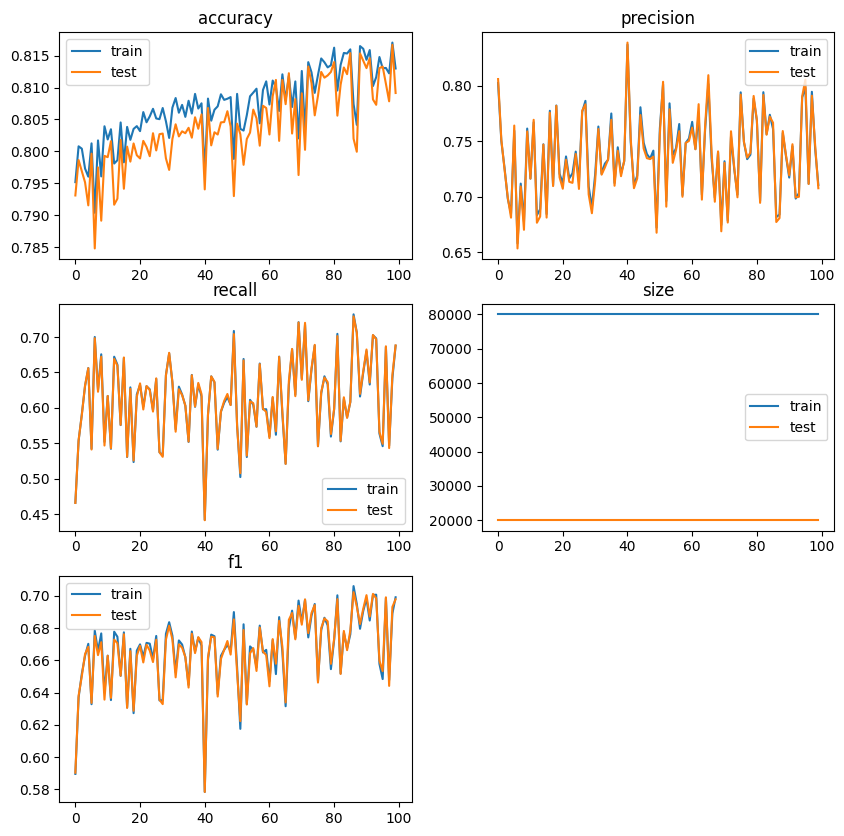

In [39]:
gcn_model = GCN(hidden_channels=11, num_node_features=ds_onehot.num_node_features,
            num_classes=ds_onehot.num_classes)
print(gcn_model)

te = TrainEval(gcn_model)
te.main(NUM_EPOCH, onehot_train_loader, onehot_test_loader)

SAGE(
  (conv1): SAGEConv(16, 11, aggr=mean)
  (conv2): SAGEConv(11, 11, aggr=mean)
  (conv3): SAGEConv(11, 11, aggr=mean)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.8022, precision=0.7491, recall=0.5620, size=80000.0000, f1=0.6422, Test: accuracy=0.7984, precision=0.7474, recall=0.5596, size=20000.0000, f1=0.6400
Epoch:  02, Train: accuracy=0.7998, precision=0.7750, recall=0.5158, size=80000.0000, f1=0.6193, Test: accuracy=0.7987, precision=0.7781, recall=0.5196, size=20000.0000, f1=0.6231
Epoch:  03, Train: accuracy=0.8039, precision=0.7804, recall=0.5276, size=80000.0000, f1=0.6296, Test: accuracy=0.8015, precision=0.7804, recall=0.5290, size=20000.0000, f1=0.6306
Epoch:  04, Train: accuracy=0.8104, precision=0.7573, recall=0.5882, size=80000.0000, f1=0.6621, Test: accuracy=0.8045, precision=0.7476, recall=0.5878, size=20000.0000, f1=0.6582
Epoch:  05, Train: accuracy=0.8132, precision=0.7489, recall=0.6147, size=80000.0000, f1=0.6752,

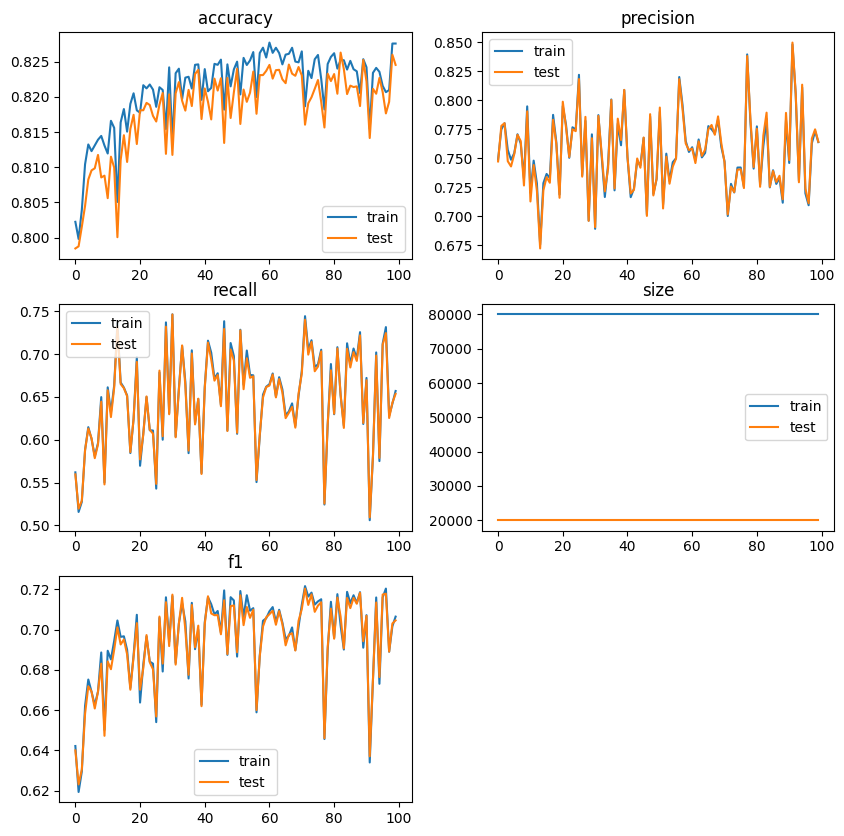

In [40]:
sage_model = SAGE(hidden_channels=11, num_node_features=ds_onehot.num_node_features,
                  num_classes=ds_onehot.num_classes)
print(sage_model)

te = TrainEval(sage_model)
te.main(NUM_EPOCH, onehot_train_loader, onehot_test_loader)

ConvGNN(
  (conv1): GraphConv(16, 11)
  (conv2): GraphConv(11, 11)
  (conv3): GraphConv(11, 11)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.8041, precision=0.7469, recall=0.5741, size=80000.0000, f1=0.6492, Test: accuracy=0.8009, precision=0.7445, recall=0.5757, size=20000.0000, f1=0.6493
Epoch:  02, Train: accuracy=0.8107, precision=0.7624, recall=0.5817, size=80000.0000, f1=0.6599, Test: accuracy=0.8057, precision=0.7553, recall=0.5814, size=20000.0000, f1=0.6571
Epoch:  03, Train: accuracy=0.8103, precision=0.7837, recall=0.5517, size=80000.0000, f1=0.6475, Test: accuracy=0.8067, precision=0.7792, recall=0.5529, size=20000.0000, f1=0.6468
Epoch:  04, Train: accuracy=0.8116, precision=0.7585, recall=0.5918, size=80000.0000, f1=0.6648, Test: accuracy=0.8073, precision=0.7527, recall=0.5928, size=20000.0000, f1=0.6633
Epoch:  05, Train: accuracy=0.8150, precision=0.7418, recall=0.6351, size=80000.0000, f1=0.6843, Test: accuracy=0.8105, pre

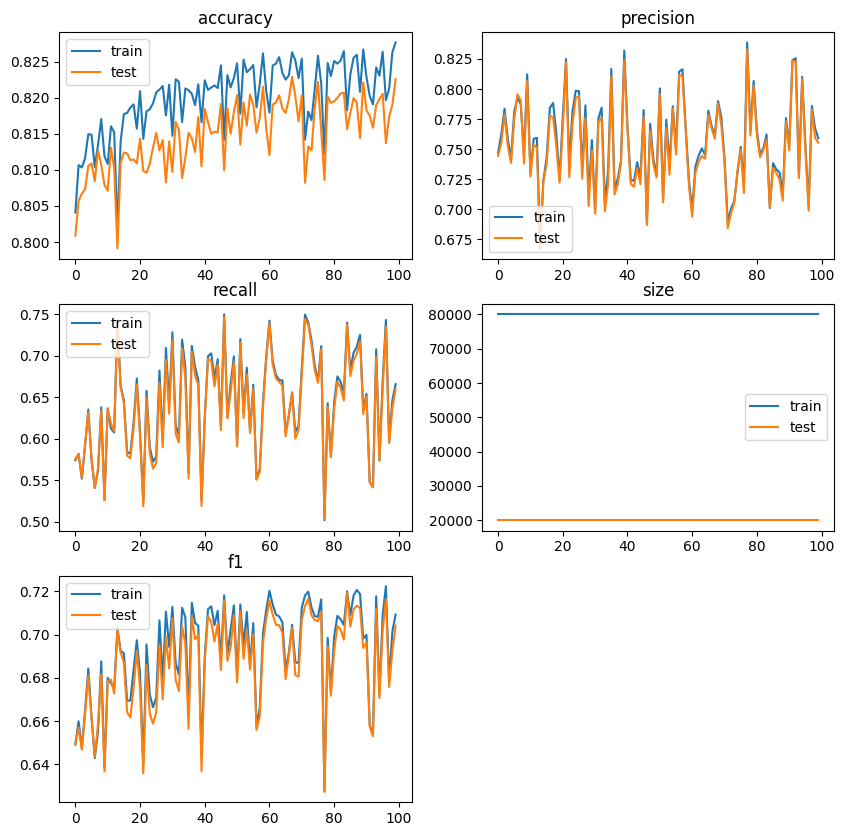

In [41]:
conv_model = ConvGNN(hidden_channels=11, num_node_features=ds_onehot.num_node_features,
                     num_classes=2)
print(conv_model)

te = TrainEval(conv_model)
te.main(NUM_EPOCH, onehot_train_loader, onehot_test_loader)

## SAGE with various number of layers and aggregations

SAGE looks better than GCN and about the same quality as Conv. It's more customizable though so I proceed with it.

CustomSAGE(
  (sage): GraphSAGE(16, 11, num_layers=3)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7915, precision=0.7922, recall=0.4604, size=80000.0000, f1=0.5823, Test: accuracy=0.7887, precision=0.7909, recall=0.4624, size=20000.0000, f1=0.5836
Epoch:  02, Train: accuracy=0.7894, precision=0.8157, recall=0.4302, size=80000.0000, f1=0.5633, Test: accuracy=0.7872, precision=0.8149, recall=0.4339, size=20000.0000, f1=0.5662
Epoch:  03, Train: accuracy=0.7950, precision=0.7703, recall=0.4996, size=80000.0000, f1=0.6061, Test: accuracy=0.7916, precision=0.7675, recall=0.5007, size=20000.0000, f1=0.6060
Epoch:  04, Train: accuracy=0.7824, precision=0.8413, recall=0.3833, size=80000.0000, f1=0.5266, Test: accuracy=0.7795, precision=0.8452, recall=0.3811, size=20000.0000, f1=0.5253
Epoch:  05, Train: accuracy=0.8008, precision=0.7431, recall=0.5644, size=80000.0000, f1=0.6415, Test: accuracy=0.7967, precision=0.7389, recall=0.5647, size=20000.0

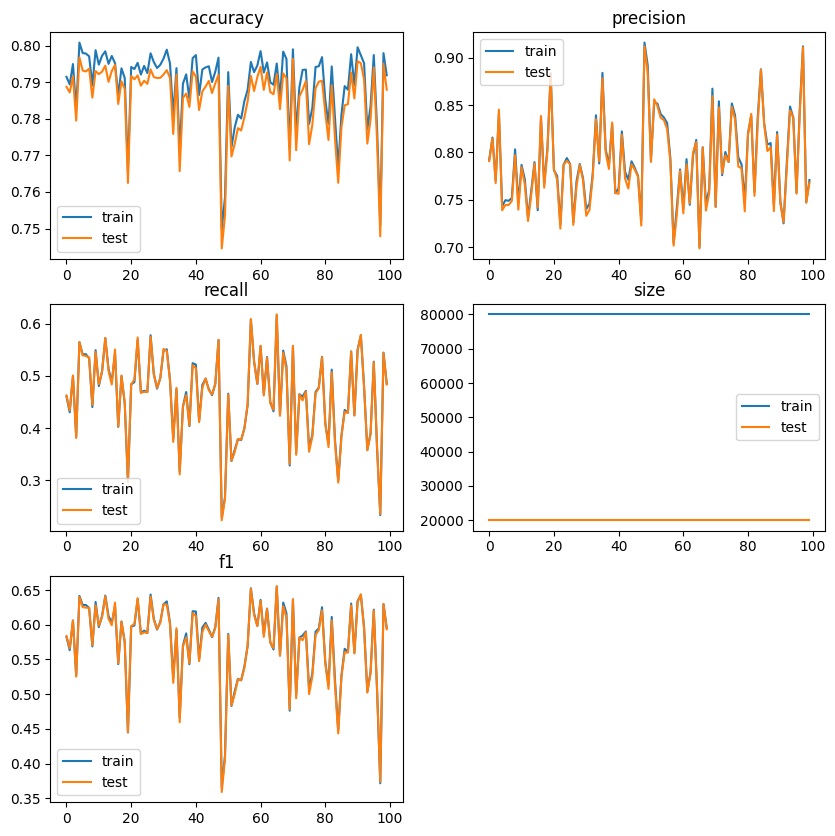

In [69]:
# 1. SAGE with sum aggregator

sage_sum_model = CustomSAGE(hidden_layers=3, hidden_channels=11, num_node_features=ds_onehot.num_node_features,
                            num_classes=2, aggr='sum')
print(sage_sum_model)

te = TrainEval(sage_sum_model)
te.main(NUM_EPOCH, onehot_train_loader, onehot_test_loader)

CustomSAGE(
  (sage): GraphSAGE(16, 11, num_layers=5)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7956, precision=0.7311, recall=0.5578, size=80000.0000, f1=0.6328, Test: accuracy=0.7896, precision=0.7224, recall=0.5568, size=20000.0000, f1=0.6289
Epoch:  02, Train: accuracy=0.7968, precision=0.7219, recall=0.5798, size=80000.0000, f1=0.6431, Test: accuracy=0.7912, precision=0.7157, recall=0.5768, size=20000.0000, f1=0.6388
Epoch:  03, Train: accuracy=0.7847, precision=0.8287, recall=0.4013, size=80000.0000, f1=0.5407, Test: accuracy=0.7800, precision=0.8188, recall=0.4017, size=20000.0000, f1=0.5390
Epoch:  04, Train: accuracy=0.7987, precision=0.7286, recall=0.5779, size=80000.0000, f1=0.6446, Test: accuracy=0.7952, precision=0.7268, recall=0.5772, size=20000.0000, f1=0.6435
Epoch:  05, Train: accuracy=0.7919, precision=0.7946, recall=0.4598, size=80000.0000, f1=0.5825, Test: accuracy=0.7874, precision=0.7894, recall=0.4584, size=20000.0

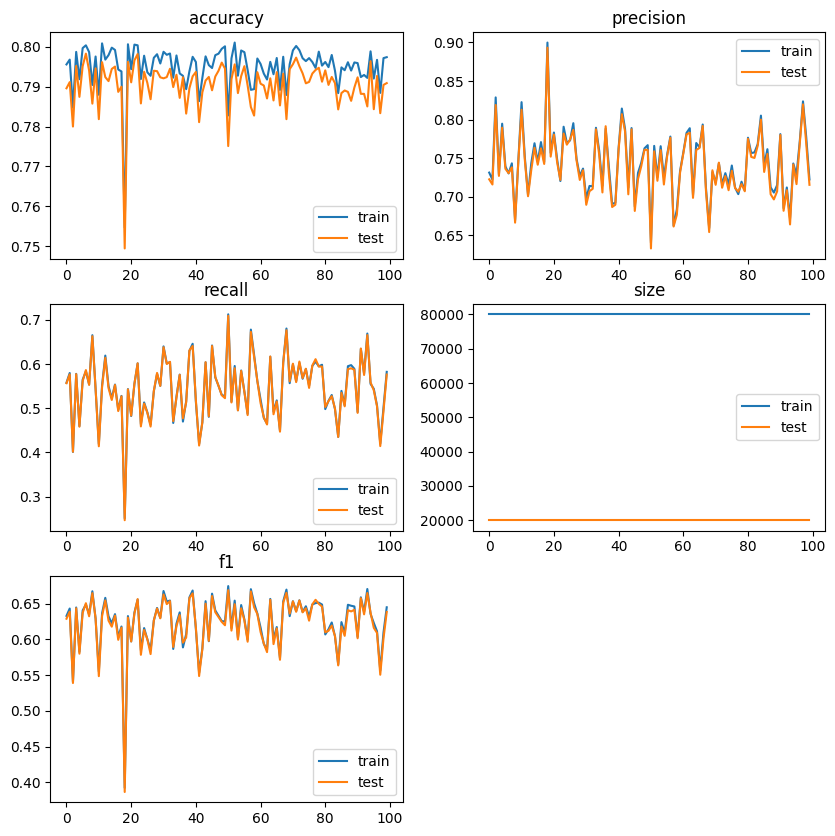

In [9]:
# 2. SAGE with 5 layers

sage_5_model = CustomSAGE(hidden_layers=5, hidden_channels=11, num_node_features=ds_onehot.num_node_features,
                            num_classes=2)
print(sage_5_model)

te = TrainEval(sage_5_model)
te.main(NUM_EPOCH, onehot_train_loader, onehot_test_loader)

In [10]:
te_s5 = te

CustomSAGE(
  (sage): GraphSAGE(16, 11, num_layers=10)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7751, precision=0.6508, recall=0.6211, size=80000.0000, f1=0.6356, Test: accuracy=0.7660, precision=0.6386, recall=0.6197, size=20000.0000, f1=0.6290
Epoch:  02, Train: accuracy=0.7830, precision=0.6535, recall=0.6659, size=80000.0000, f1=0.6596, Test: accuracy=0.7744, precision=0.6429, recall=0.6648, size=20000.0000, f1=0.6537
Epoch:  03, Train: accuracy=0.7892, precision=0.6786, recall=0.6311, size=80000.0000, f1=0.6540, Test: accuracy=0.7806, precision=0.6659, recall=0.6319, size=20000.0000, f1=0.6484
Epoch:  04, Train: accuracy=0.7925, precision=0.7061, recall=0.5876, size=80000.0000, f1=0.6414, Test: accuracy=0.7872, precision=0.6994, recall=0.5882, size=20000.0000, f1=0.6390
Epoch:  05, Train: accuracy=0.7837, precision=0.6668, recall=0.6298, size=80000.0000, f1=0.6477, Test: accuracy=0.7785, precision=0.6621, recall=0.6294, size=20000.

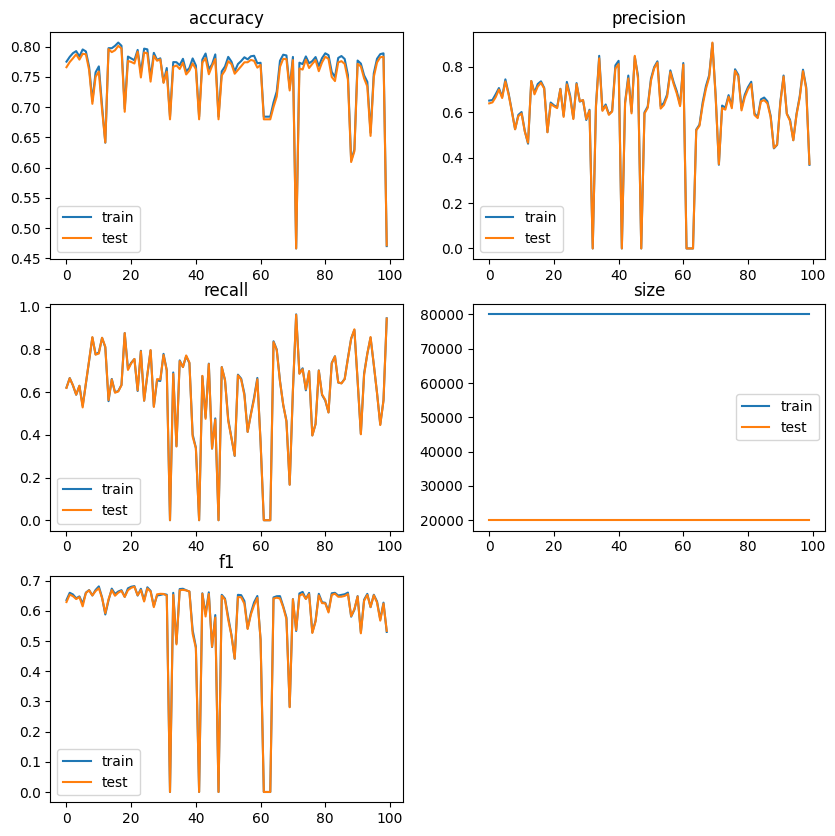

In [7]:
# 3. SAGE with 10 layers

sage_10_model = CustomSAGE(hidden_layers=10, hidden_channels=11, num_node_features=ds_onehot.num_node_features,
                          num_classes=2)
print(sage_10_model)

te_s10 = TrainEval(sage_10_model)
te_s10.main(NUM_EPOCH, onehot_train_loader, onehot_test_loader)

In [8]:
# Lets train SAGE-10 with 100 more epoch

te_s10.main(NUM_EPOCH, onehot_train_loader, onehot_test_loader)

Epoch:  01, Train: accuracy=0.6225, precision=0.4519, recall=0.9170, size=80000.0000, f1=0.6054, Test: accuracy=0.6200, precision=0.4538, recall=0.9186, size=20000.0000, f1=0.6075
Epoch:  02, Train: accuracy=0.7454, precision=0.5726, recall=0.7640, size=80000.0000, f1=0.6546, Test: accuracy=0.7388, precision=0.5680, recall=0.7687, size=20000.0000, f1=0.6533
Epoch:  03, Train: accuracy=0.7894, precision=0.7162, recall=0.5518, size=80000.0000, f1=0.6233, Test: accuracy=0.7845, precision=0.7102, recall=0.5526, size=20000.0000, f1=0.6215
Epoch:  04, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  05, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  06, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Tes

KeyboardInterrupt: 

CustomSAGE(
  (sage): GraphSAGE(16, 20, num_layers=3)
  (lin): Linear(in_features=20, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.8004, precision=0.7668, recall=0.5284, size=80000.0000, f1=0.6257, Test: accuracy=0.7961, precision=0.7628, recall=0.5268, size=20000.0000, f1=0.6232
Epoch:  02, Train: accuracy=0.8013, precision=0.7117, recall=0.6229, size=80000.0000, f1=0.6644, Test: accuracy=0.7958, precision=0.7059, recall=0.6208, size=20000.0000, f1=0.6606
Epoch:  03, Train: accuracy=0.7947, precision=0.6694, recall=0.6913, size=80000.0000, f1=0.6802, Test: accuracy=0.7910, precision=0.6680, recall=0.6898, size=20000.0000, f1=0.6788
Epoch:  04, Train: accuracy=0.8015, precision=0.7432, recall=0.5675, size=80000.0000, f1=0.6435, Test: accuracy=0.7982, precision=0.7404, recall=0.5690, size=20000.0000, f1=0.6435
Epoch:  05, Train: accuracy=0.8003, precision=0.7756, recall=0.5173, size=80000.0000, f1=0.6207, Test: accuracy=0.7982, precision=0.7786, recall=0.5163, size=20000.0

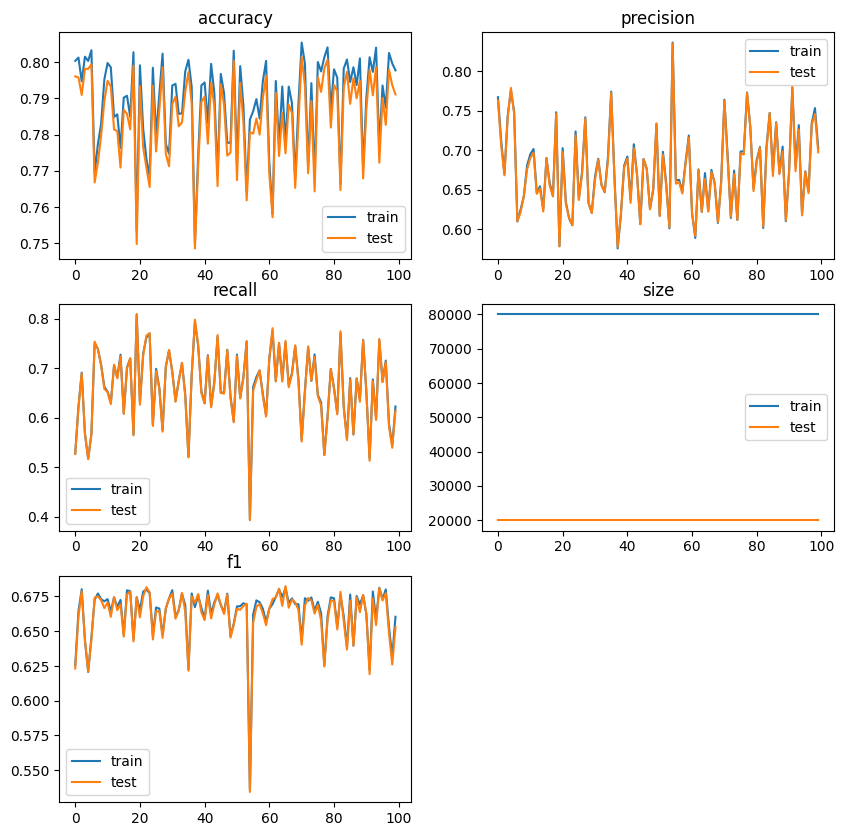

In [18]:
# 4. SAGE with 3 layers but 20 hidden channels

sage_hc20_model = CustomSAGE(hidden_layers=3, hidden_channels=20, num_node_features=ds_onehot.num_node_features,
                            num_classes=2)
print(sage_hc20_model)

te = TrainEval(sage_hc20_model)
te.main(NUM_EPOCH, onehot_train_loader, onehot_test_loader)

## NN

Epoch:  01, Train: accuracy=0.8174, precision=0.8115, recall=0.5494, size=80000.0000, f1=0.6552, Test: accuracy=0.8153, precision=0.8112, recall=0.5515, size=20000.0000, f1=0.6566
Epoch:  02, Train: accuracy=0.8213, precision=0.7202, recall=0.7096, size=80000.0000, f1=0.7149, Test: accuracy=0.8166, precision=0.7169, recall=0.7059, size=20000.0000, f1=0.7114
Epoch:  03, Train: accuracy=0.8224, precision=0.7808, recall=0.6083, size=80000.0000, f1=0.6838, Test: accuracy=0.8215, precision=0.7850, recall=0.6091, size=20000.0000, f1=0.6860
Epoch:  04, Train: accuracy=0.8223, precision=0.7833, recall=0.6044, size=80000.0000, f1=0.6823, Test: accuracy=0.8214, precision=0.7871, recall=0.6061, size=20000.0000, f1=0.6848
Epoch:  05, Train: accuracy=0.8209, precision=0.7990, recall=0.5785, size=80000.0000, f1=0.6711, Test: accuracy=0.8179, precision=0.7967, recall=0.5791, size=20000.0000, f1=0.6707
Epoch:  06, Train: accuracy=0.8233, precision=0.7727, recall=0.6237, size=80000.0000, f1=0.6903, Tes

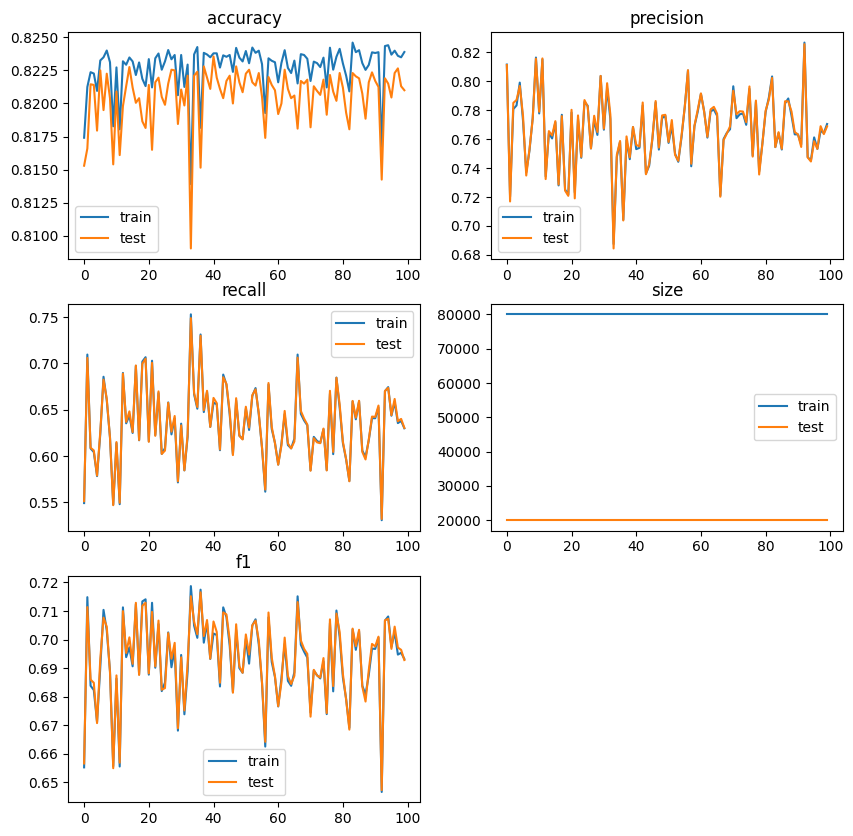

In [51]:
fc_model = nn.Sequential(
    nn.Linear(16, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 2),
)

te = TrainEvalGraphless(fc_model)
te.main(NUM_EPOCH, onehot_train_loader, onehot_test_loader)

# Features: constant, avg_nodes: 15

In [13]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 2
max_degree = 15 

constant = Constant(value=1.0, cat=False)

ds_const = FakeDatasetIsPlanar(num_graphs=NUM_GRAPHS, avg_num_nodes=15, avg_degree=avg_degree,
                               transform=constant)

print(f"Planar graphs: {int(ds_const.y.sum())}")
ds_const

Planar graphs: 31665
CPU times: user 40.7 s, sys: 79.6 ms, total: 40.8 s
Wall time: 40.9 s


FakeDatasetIsPlanar(100000)

In [14]:
ds_const_train_loader, ds_const_test_loader = split_dataset(ds_const)

Number of training graphs: 80000
Number of test graphs: 20000


GCN(
  (conv1): GCNConv(1, 10)
  (conv2): GCNConv(10, 10)
  (conv3): GCNConv(10, 10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  02, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  03, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  04, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  05, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.00

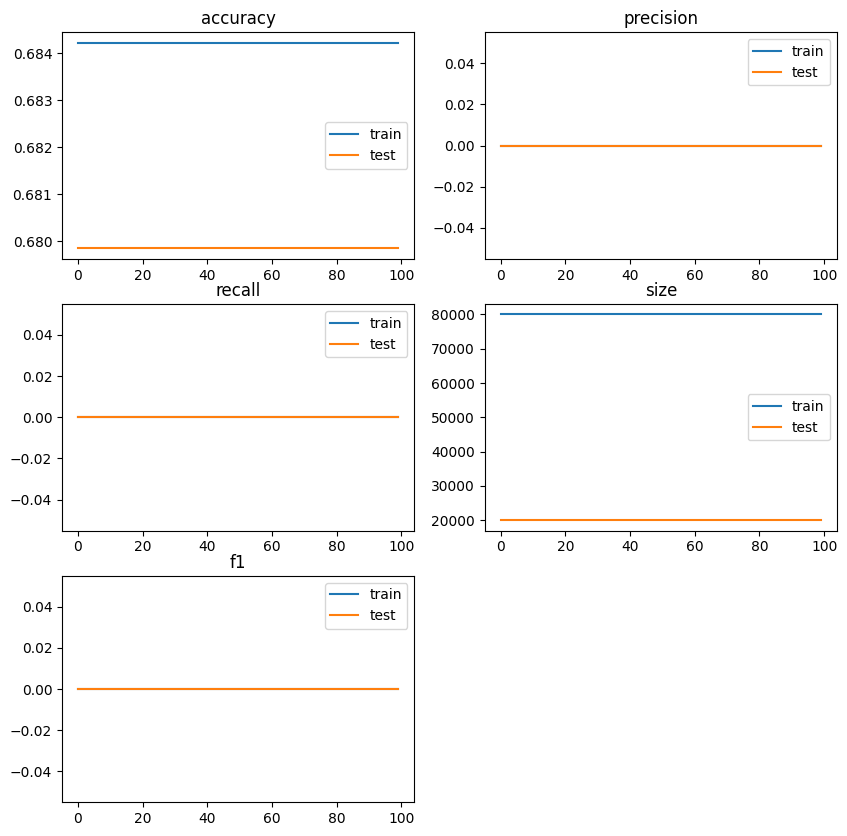

In [48]:
gcn_model = GCN(hidden_channels=10, num_node_features=ds_const.num_node_features,
            num_classes=ds_const.num_classes)
print(gcn_model)

te = TrainEval(gcn_model)
te.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)

SAGE(
  (conv1): SAGEConv(1, 10, aggr=mean)
  (conv2): SAGEConv(10, 10, aggr=mean)
  (conv3): SAGEConv(10, 10, aggr=mean)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  02, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  03, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  04, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  05, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, 

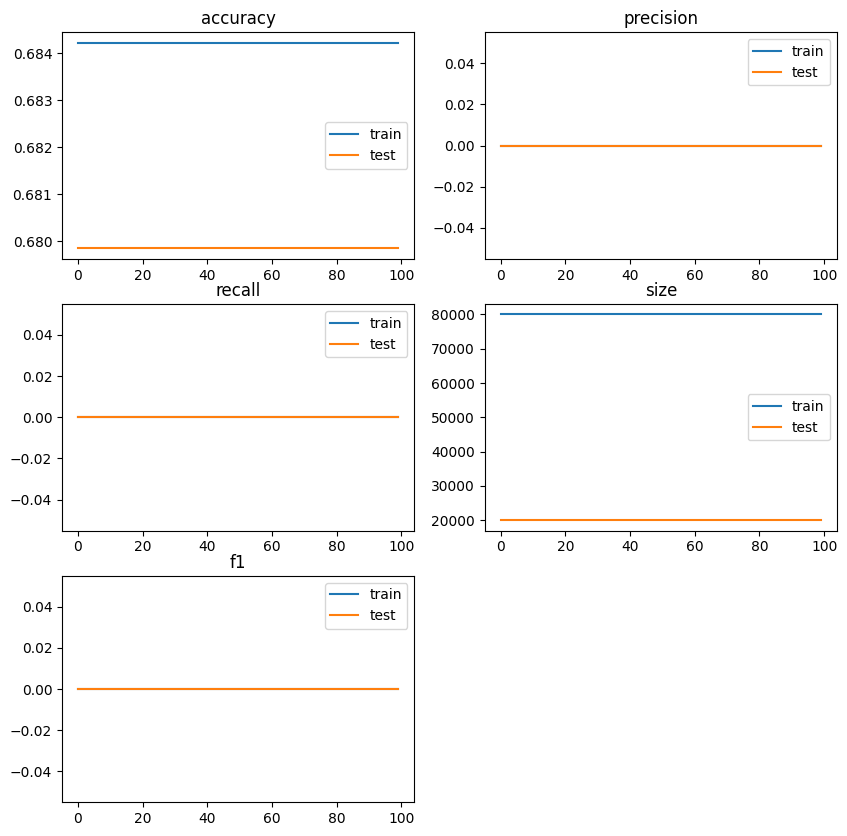

In [49]:
sage_model = SAGE(hidden_channels=10, num_node_features=ds_const.num_node_features,
                  num_classes=ds_const.num_classes)
print(sage_model)

te = TrainEval(sage_model)
te.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)

ConvGNN(
  (conv1): GraphConv(1, 10)
  (conv2): GraphConv(10, 10)
  (conv3): GraphConv(10, 10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7980, precision=0.7524, recall=0.5371, size=80000.0000, f1=0.6267, Test: accuracy=0.7945, precision=0.7514, recall=0.5354, size=20000.0000, f1=0.6253
Epoch:  02, Train: accuracy=0.7983, precision=0.7765, recall=0.5073, size=80000.0000, f1=0.6137, Test: accuracy=0.7956, precision=0.7774, recall=0.5066, size=20000.0000, f1=0.6135
Epoch:  03, Train: accuracy=0.7305, precision=0.5483, recall=0.8321, size=80000.0000, f1=0.6610, Test: accuracy=0.7266, precision=0.5480, recall=0.8321, size=20000.0000, f1=0.6608
Epoch:  04, Train: accuracy=0.7970, precision=0.6960, recall=0.6341, size=80000.0000, f1=0.6636, Test: accuracy=0.7935, precision=0.6946, recall=0.6336, size=20000.0000, f1=0.6627
Epoch:  05, Train: accuracy=0.8006, precision=0.7253, recall=0.5935, size=80000.0000, f1=0.6528, Test: accuracy=0.7974, prec

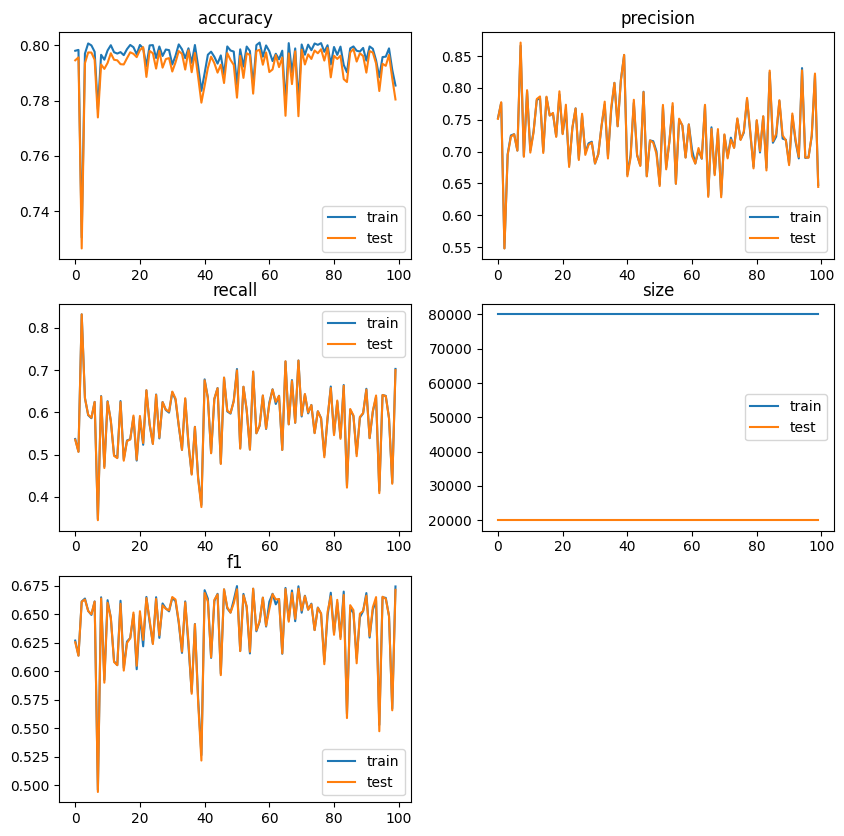

In [50]:
conv_model = ConvGNN(hidden_channels=10, num_node_features=ds_const.num_node_features,
                     num_classes=ds_const.num_classes)
print(conv_model)

te = TrainEval(conv_model)
te.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)

ConvGNN(
  (conv1): GraphConv(1, 10)
  (conv2): GraphConv(10, 10)
  (conv3): GraphConv(10, 10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7979, precision=0.7284, recall=0.5739, size=80000.0000, f1=0.6420, Test: accuracy=0.7951, precision=0.7265, recall=0.5774, size=20000.0000, f1=0.6434
Epoch:  02, Train: accuracy=0.7986, precision=0.7671, recall=0.5200, size=80000.0000, f1=0.6198, Test: accuracy=0.7958, precision=0.7662, recall=0.5215, size=20000.0000, f1=0.6206
Epoch:  03, Train: accuracy=0.7988, precision=0.7701, recall=0.5175, size=80000.0000, f1=0.6190, Test: accuracy=0.7955, precision=0.7693, recall=0.5160, size=20000.0000, f1=0.6177
Epoch:  04, Train: accuracy=0.7884, precision=0.8271, recall=0.4173, size=80000.0000, f1=0.5547, Test: accuracy=0.7834, precision=0.8247, recall=0.4107, size=20000.0000, f1=0.5484
Epoch:  05, Train: accuracy=0.7987, precision=0.7373, recall=0.5631, size=80000.0000, f1=0.6386, Test: accuracy=0.7945, prec

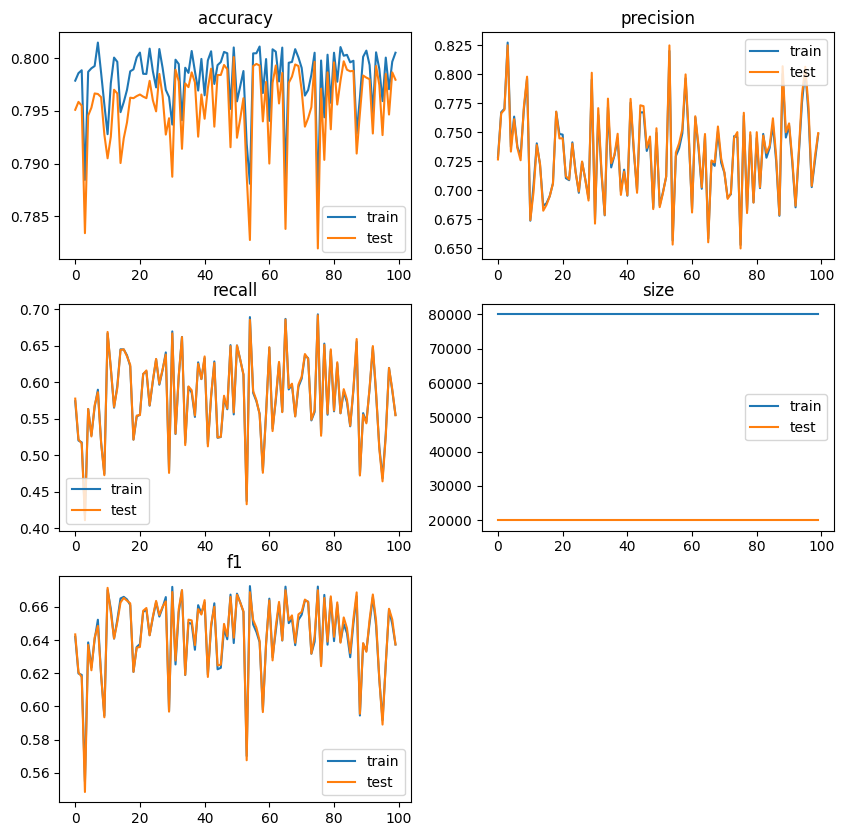

In [66]:
conv_model = ConvGNN(hidden_channels=10, num_node_features=ds_const.num_node_features,
                     num_classes=ds_const.num_classes, apply_dropout=False)
print(conv_model)

te = TrainEval(conv_model)
te.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)

CustomSAGE(
  (sage): GraphSAGE(1, 10, num_layers=3)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7979, precision=0.7284, recall=0.5739, size=80000.0000, f1=0.6420, Test: accuracy=0.7951, precision=0.7265, recall=0.5774, size=20000.0000, f1=0.6434
Epoch:  02, Train: accuracy=0.7986, precision=0.7671, recall=0.5200, size=80000.0000, f1=0.6198, Test: accuracy=0.7958, precision=0.7662, recall=0.5215, size=20000.0000, f1=0.6206
Epoch:  03, Train: accuracy=0.7988, precision=0.7701, recall=0.5175, size=80000.0000, f1=0.6190, Test: accuracy=0.7955, precision=0.7693, recall=0.5160, size=20000.0000, f1=0.6177
Epoch:  04, Train: accuracy=0.7884, precision=0.8271, recall=0.4173, size=80000.0000, f1=0.5547, Test: accuracy=0.7834, precision=0.8247, recall=0.4107, size=20000.0000, f1=0.5484
Epoch:  05, Train: accuracy=0.7987, precision=0.7373, recall=0.5631, size=80000.0000, f1=0.6386, Test: accuracy=0.7945, precision=0.7332, recall=0.5632, size=20000.00

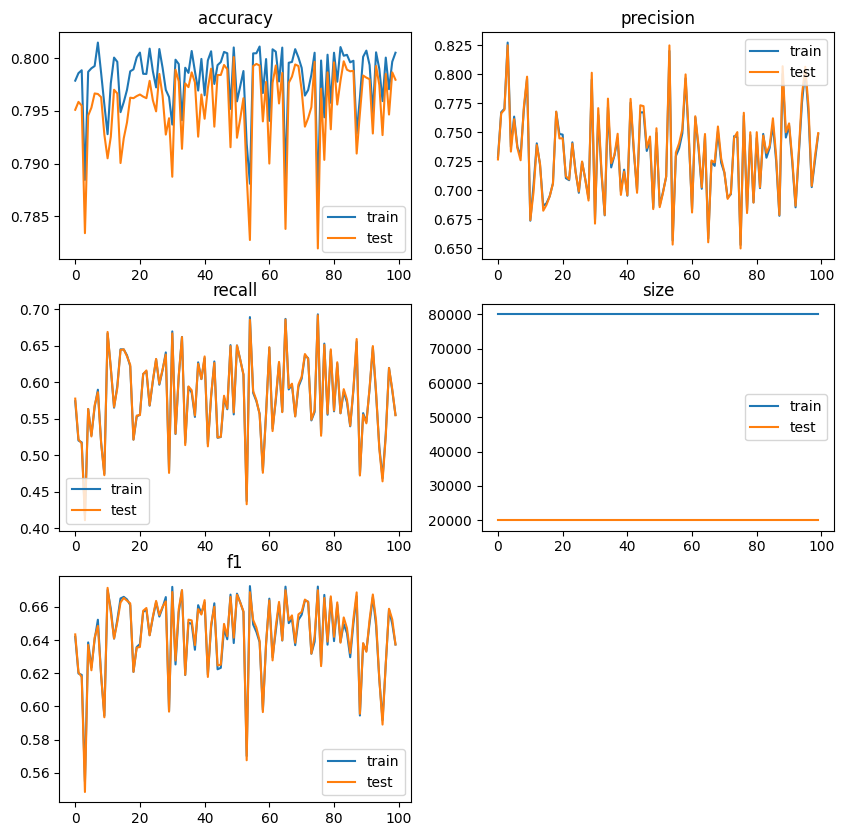

In [65]:
sage_sum_model = CustomSAGE(hidden_layers=3, hidden_channels=10, num_node_features=ds_const.num_node_features,
                            num_classes=ds_const.num_classes, apply_dropout=False, aggr='sum')
print(sage_sum_model)

te = TrainEval(sage_sum_model)
te.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)

CustomSAGE(
  (sage): GraphSAGE(1, 10, num_layers=3)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7979, precision=0.7284, recall=0.5739, size=80000.0000, f1=0.6420, Test: accuracy=0.7951, precision=0.7265, recall=0.5774, size=20000.0000, f1=0.6434
Epoch:  02, Train: accuracy=0.7986, precision=0.7671, recall=0.5200, size=80000.0000, f1=0.6198, Test: accuracy=0.7958, precision=0.7662, recall=0.5215, size=20000.0000, f1=0.6206
Epoch:  03, Train: accuracy=0.7988, precision=0.7701, recall=0.5175, size=80000.0000, f1=0.6190, Test: accuracy=0.7955, precision=0.7693, recall=0.5160, size=20000.0000, f1=0.6177
Epoch:  04, Train: accuracy=0.7884, precision=0.8271, recall=0.4173, size=80000.0000, f1=0.5547, Test: accuracy=0.7834, precision=0.8247, recall=0.4107, size=20000.0000, f1=0.5484
Epoch:  05, Train: accuracy=0.7987, precision=0.7373, recall=0.5631, size=80000.0000, f1=0.6386, Test: accuracy=0.7945, precision=0.7332, recall=0.5632, size=20000.00

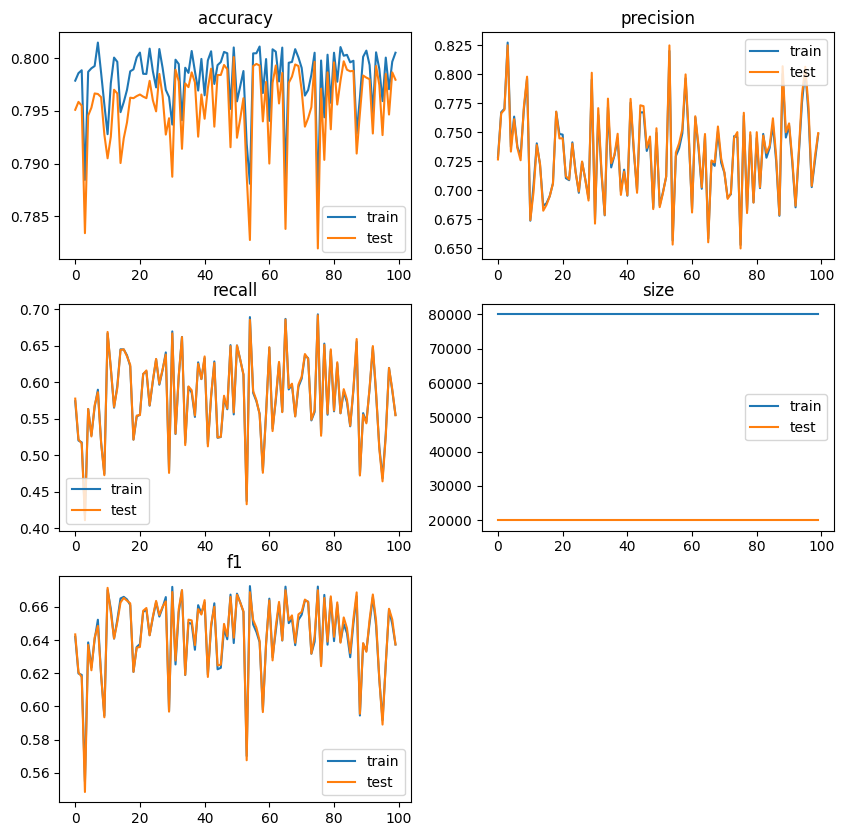

In [21]:
sage_sum_model = CustomSAGE(hidden_layers=3, hidden_channels=10, num_node_features=ds_const.num_node_features,
                            num_classes=ds_const.num_classes, apply_dropout=False, aggr='sum')
print(sage_sum_model)

te = TrainEval(sage_sum_model)
te.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)

SAGE with sum aggregation is expectedly having an identical curve to ConvGNN as they are equivalent and initiated with the same seed.

CustomSAGE(
  (sage): GraphSAGE(1, 10, num_layers=3)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7766, precision=0.8369, recall=0.3635, size=80000.0000, f1=0.5068, Test: accuracy=0.7710, precision=0.8261, recall=0.3605, size=20000.0000, f1=0.5019
Epoch:  02, Train: accuracy=0.7715, precision=0.8561, recall=0.3321, size=80000.0000, f1=0.4785, Test: accuracy=0.7651, precision=0.8504, recall=0.3231, size=20000.0000, f1=0.4683
Epoch:  03, Train: accuracy=0.7897, precision=0.7382, recall=0.5177, size=80000.0000, f1=0.6086, Test: accuracy=0.7846, precision=0.7324, recall=0.5159, size=20000.0000, f1=0.6053
Epoch:  04, Train: accuracy=0.7676, precision=0.8636, recall=0.3134, size=80000.0000, f1=0.4599, Test: accuracy=0.7617, precision=0.8585, recall=0.3061, size=20000.0000, f1=0.4513
Epoch:  05, Train: accuracy=0.7823, precision=0.8138, recall=0.4029, size=80000.0000, f1=0.5390, Test: accuracy=0.7785, precision=0.8114, recall=0.4017, size=20000.00

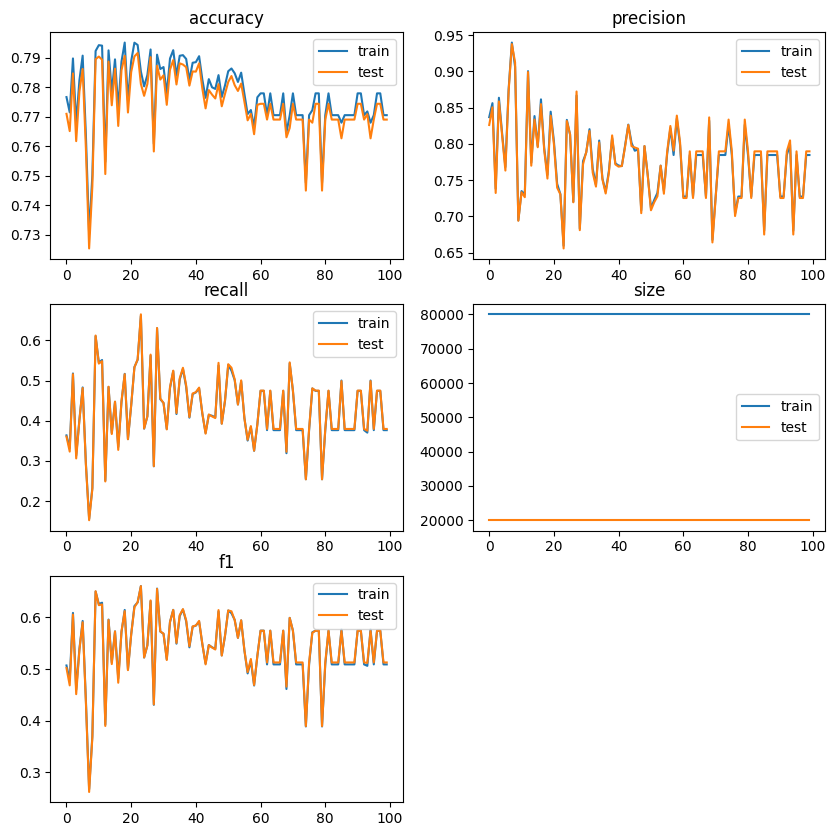

In [15]:
sage_sum_model = CustomSAGE(hidden_layers=3, hidden_channels=10, num_node_features=ds_const.num_node_features,
                            num_classes=ds_const.num_classes, aggr='sum')
print(sage_sum_model)

te = TrainEval(sage_sum_model)
te.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)

CustomSAGE(
  (sage): GraphSAGE(1, 10, num_layers=5)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.8023, precision=0.7857, recall=0.5141, size=80000.0000, f1=0.6215, Test: accuracy=0.7961, precision=0.7747, recall=0.5118, size=20000.0000, f1=0.6164
Epoch:  02, Train: accuracy=0.7882, precision=0.8511, recall=0.3989, size=80000.0000, f1=0.5432, Test: accuracy=0.7834, precision=0.8453, recall=0.3961, size=20000.0000, f1=0.5394
Epoch:  03, Train: accuracy=0.8080, precision=0.7778, recall=0.5488, size=80000.0000, f1=0.6435, Test: accuracy=0.8030, precision=0.7723, recall=0.5452, size=20000.0000, f1=0.6392
Epoch:  04, Train: accuracy=0.8127, precision=0.7367, recall=0.6330, size=80000.0000, f1=0.6809, Test: accuracy=0.8072, precision=0.7319, recall=0.6275, size=20000.0000, f1=0.6757
Epoch:  05, Train: accuracy=0.7774, precision=0.9123, recall=0.3264, size=80000.0000, f1=0.4808, Test: accuracy=0.7733, precision=0.9104, recall=0.3239, size=20000.00

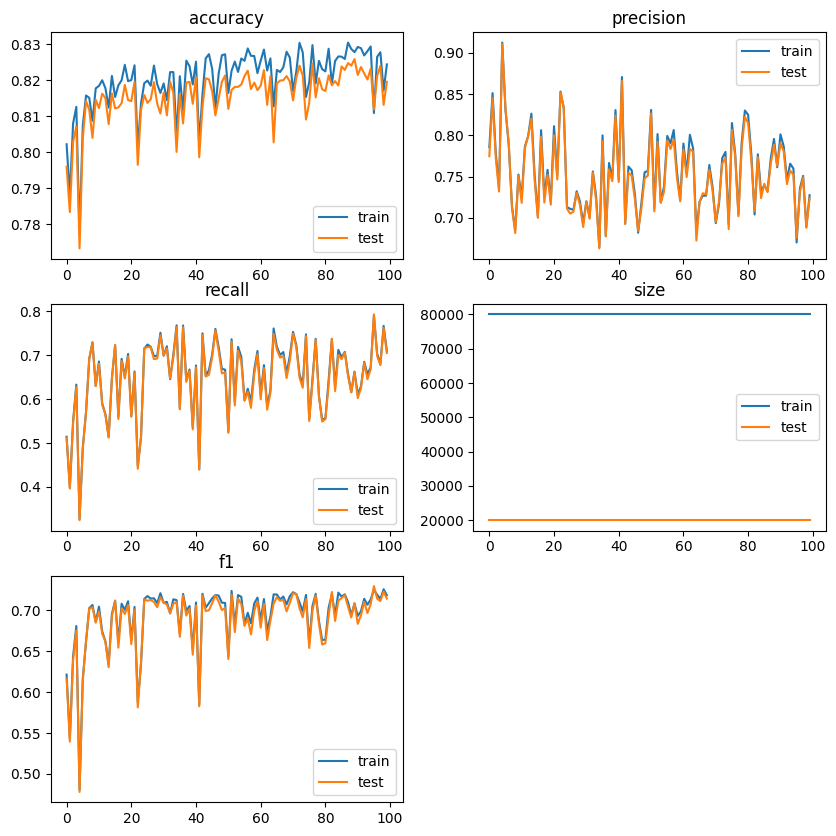

In [22]:
sage_5_model = CustomSAGE(hidden_layers=5, hidden_channels=10, num_node_features=ds_const.num_node_features,
                            num_classes=ds_const.num_classes, apply_dropout=False, aggr='sum')
print(sage_5_model)

te_s5_c = TrainEval(sage_5_model)
te_s5_c.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)

CustomSAGE(
  (sage): GraphSAGE(1, 10, num_layers=5)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7842, precision=0.7267, recall=0.5072, size=80000.0000, f1=0.5975, Test: accuracy=0.7802, precision=0.7238, recall=0.5068, size=20000.0000, f1=0.5962
Epoch:  02, Train: accuracy=0.7875, precision=0.7732, recall=0.4631, size=80000.0000, f1=0.5792, Test: accuracy=0.7855, precision=0.7748, recall=0.4654, size=20000.0000, f1=0.5815
Epoch:  03, Train: accuracy=0.7846, precision=0.7962, recall=0.4272, size=80000.0000, f1=0.5560, Test: accuracy=0.7805, precision=0.7920, recall=0.4264, size=20000.0000, f1=0.5543
Epoch:  04, Train: accuracy=0.7871, precision=0.6721, recall=0.6362, size=80000.0000, f1=0.6537, Test: accuracy=0.7850, precision=0.6726, recall=0.6399, size=20000.0000, f1=0.6558
Epoch:  05, Train: accuracy=0.7822, precision=0.6643, recall=0.6269, size=80000.0000, f1=0.6451, Test: accuracy=0.7800, precision=0.6646, recall=0.6314, size=20000.00

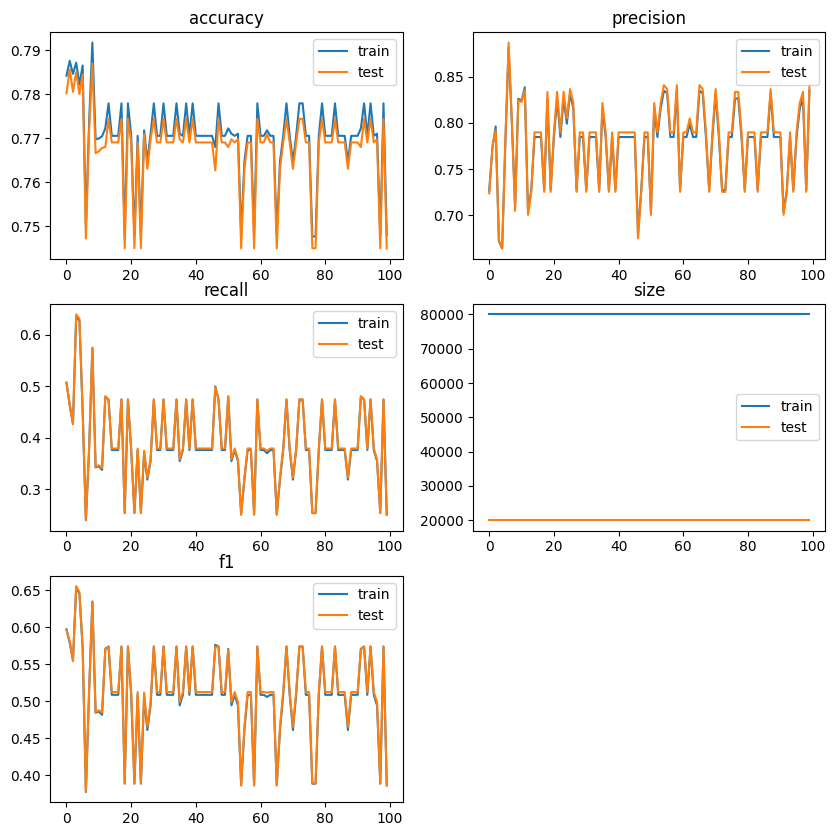

In [19]:
sage_5_model = CustomSAGE(hidden_layers=5, hidden_channels=10, num_node_features=ds_const.num_node_features,
                            num_classes=ds_const.num_classes, aggr='sum')
print(sage_5_model)

te_s5_c = TrainEval(sage_5_model)
te_s5_c.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)

CustomSAGE(
  (sage): GraphSAGE(1, 10, num_layers=10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7600, precision=0.7202, recall=0.3923, size=80000.0000, f1=0.5079, Test: accuracy=0.7530, precision=0.7034, recall=0.3953, size=20000.0000, f1=0.5061
Epoch:  02, Train: accuracy=0.7852, precision=0.7399, recall=0.4932, size=80000.0000, f1=0.5919, Test: accuracy=0.7786, precision=0.7279, recall=0.4926, size=20000.0000, f1=0.5876
Epoch:  03, Train: accuracy=0.7582, precision=0.8349, recall=0.2919, size=80000.0000, f1=0.4326, Test: accuracy=0.7561, precision=0.8349, recall=0.2970, size=20000.0000, f1=0.4382
Epoch:  04, Train: accuracy=0.7598, precision=0.6000, recall=0.7185, size=80000.0000, f1=0.6539, Test: accuracy=0.7492, precision=0.5901, recall=0.7101, size=20000.0000, f1=0.6446
Epoch:  05, Train: accuracy=0.7825, precision=0.7763, recall=0.4371, size=80000.0000, f1=0.5593, Test: accuracy=0.7777, precision=0.7704, recall=0.4354, size=20000.0

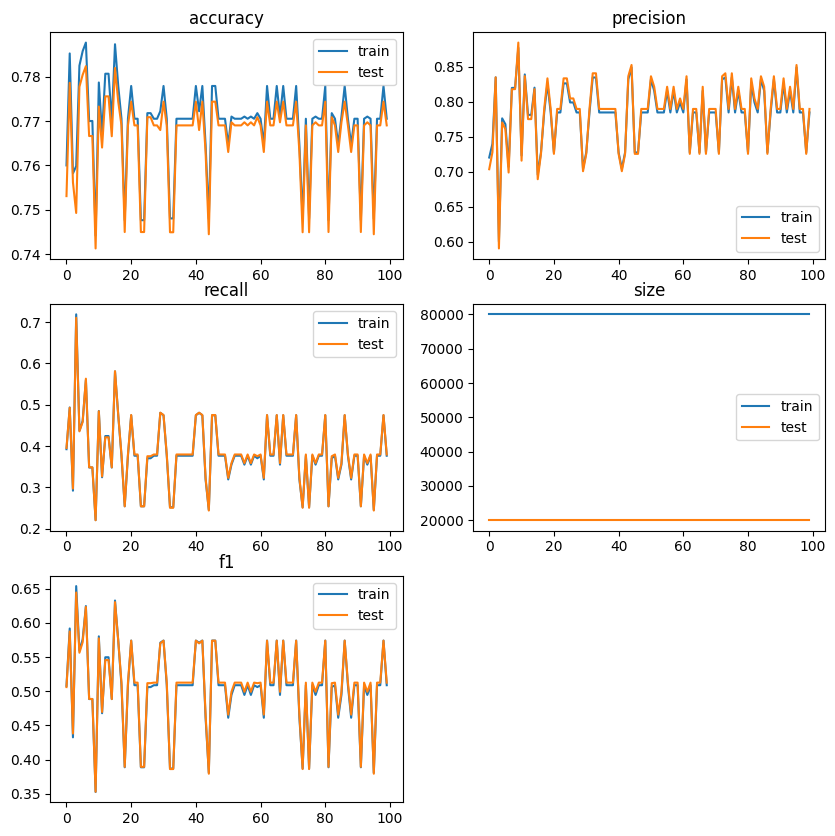

In [20]:
sage_10_model = CustomSAGE(hidden_layers=10, hidden_channels=10, num_node_features=ds_const.num_node_features,
                            num_classes=ds_const.num_classes, aggr='sum')
print(sage_10_model)

te = TrainEval(sage_10_model)
te.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)

CustomSAGE(
  (sage): GraphSAGE(1, 10, num_layers=10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.8051, precision=0.7328, recall=0.6024, size=80000.0000, f1=0.6613, Test: accuracy=0.7992, precision=0.7256, recall=0.5996, size=20000.0000, f1=0.6566
Epoch:  02, Train: accuracy=0.8060, precision=0.6892, recall=0.7022, size=80000.0000, f1=0.6957, Test: accuracy=0.8021, precision=0.6881, recall=0.6983, size=20000.0000, f1=0.6931
Epoch:  03, Train: accuracy=0.8121, precision=0.7473, recall=0.6117, size=80000.0000, f1=0.6728, Test: accuracy=0.8075, precision=0.7434, recall=0.6086, size=20000.0000, f1=0.6693
Epoch:  04, Train: accuracy=0.7527, precision=0.9251, recall=0.2360, size=80000.0000, f1=0.3761, Test: accuracy=0.7483, precision=0.9265, recall=0.2324, size=20000.0000, f1=0.3716
Epoch:  05, Train: accuracy=0.8051, precision=0.7582, recall=0.5619, size=80000.0000, f1=0.6455, Test: accuracy=0.8025, precision=0.7602, recall=0.5599, size=20000.0

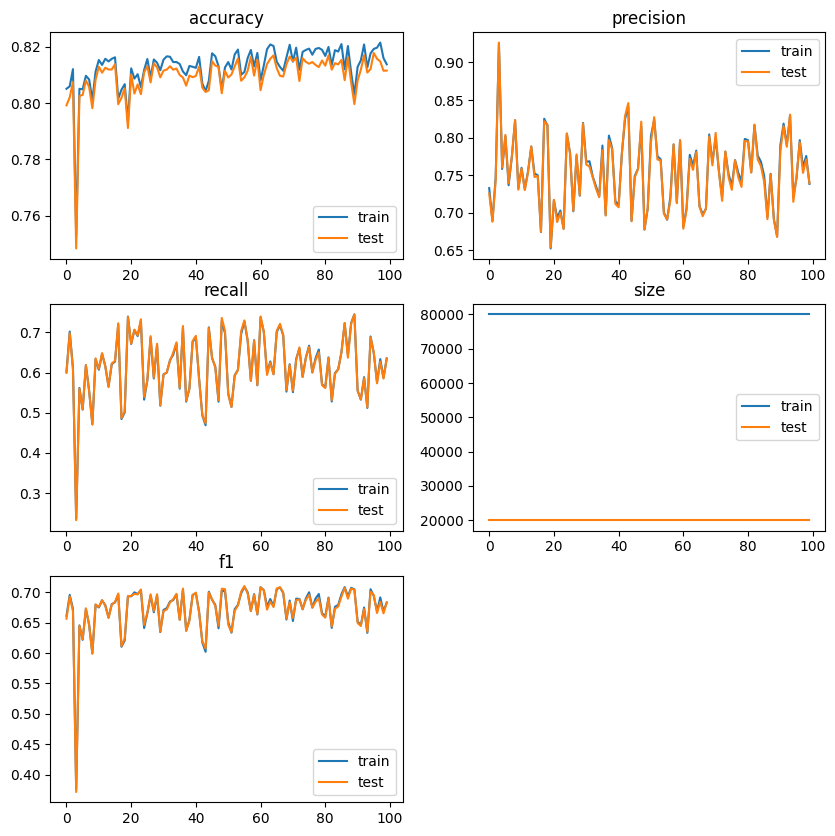

In [23]:
sage_10_model = CustomSAGE(hidden_layers=10, hidden_channels=10, num_node_features=ds_const.num_node_features,
                            num_classes=ds_const.num_classes, apply_dropout=False, aggr='sum')
print(sage_10_model)

te = TrainEval(sage_10_model)
te.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)

# Playground

In [55]:
sage5_model = CustomSAGE(hidden_layers=5, hidden_channels=10, num_node_features=ds_const.num_node_features,
                         num_classes=ds_const.num_classes, aggr='sum')
print(sage5_model)

CustomSAGE(
  (sage): GraphSAGE(1, 10, num_layers=5)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)


In [57]:
sage5_model.sage

GraphSAGE(1, 10, num_layers=5)


In [63]:
sage5_model(ds_const[0].x, ds_const[0].edge_index, torch.zeros((ds_const[0].num_nodes,), dtype=torch.long))

tensor([[-4.4967, -4.1845]], grad_fn=<AddmmBackward0>)